# Finding the best k-mer value

In [1]:
import os
# import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline

In [2]:
def kmer_count(seq, size=6):
    return [seq[x: x+size].lower() for x in
            range(len(seq) - size+1)]

In [3]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1

In [4]:
human_dna = pd.read_table('../Data/human.txt')
chimp_dna = pd.read_table('../Data/chimpanzee.txt')
dog_dna = pd.read_table('../Data/dog.txt')

In [31]:
# drop all duplicates
dog_dna.drop_duplicates(inplace=True)
human_dna.drop_duplicates(inplace=True)
chimp_dna.drop_duplicates(inplace=True)

In [32]:
metric_values_kmer = dict()

In [33]:
def complete_prediction(classifier, size):
  metric_values = dict()
  human_dna['words'] = human_dna.apply(lambda x: kmer_count(x['sequence'], size), axis=1)
  dog_dna['words'] = dog_dna.apply(lambda x: kmer_count(x['sequence'], size), axis=1)
  chimp_dna['words'] = chimp_dna.apply(lambda x: kmer_count(x['sequence'], size), axis=1)


  human_texts = list(human_dna['words'])
  for item in range(len(human_texts)):
      human_texts[item] = ' '.join(human_texts[item])
  #separate labels
  y_human = human_dna.iloc[:, 1].values # y_human for human_dna
  chimp_texts = list(chimp_dna['words'])
  for item in range(len(chimp_texts)):
      chimp_texts[item] = ' '.join(chimp_texts[item])
  #separate labels
  y_chim = chimp_dna.iloc[:, 1].values # y_chim for chimp_dna

  dog_texts = list(dog_dna['words'])
  for item in range(len(dog_texts)):
      dog_texts[item] = ' '.join(dog_texts[item])
  #separate labels
  y_dog = dog_dna.iloc[:, 1].values  # y_dog for dog_dna

  cv = CountVectorizer(ngram_range = (size, size))
  X_human = cv.fit_transform(human_texts)
  X_chimp = cv.transform(chimp_texts)
  X_dog = cv.transform(dog_texts)


  X_train, X_test, y_train, y_test = train_test_split(X_human,
                                                    y_human,
                                                    test_size = 0.20,
                                                    random_state=42)

  classifier = MultinomialNB(alpha=0.1)
  classifier.fit(X_train, y_train)

  y_pred_human = classifier.predict(X_human)
  accuracy, precision, recall, f1 = get_metrics(y_human, y_pred_human)
  metric_values["human"] = [accuracy, precision, recall, f1]

  y_pred_dog = classifier.predict(X_dog)
  accuracy, precision, recall, f1 = get_metrics(y_dog, y_pred_dog)
  metric_values["dog"] = [accuracy, precision, recall, f1]

  y_pred_chim = classifier.predict(X_chimp)
  accuracy, precision, recall, f1 = get_metrics(y_chim, y_pred_chim)
  metric_values["chimp"] = [accuracy, precision, recall, f1]
  return metric_values

In [34]:
for size in range(2, 13, 2):
    classifier = MultinomialNB(alpha=0.1)
# classifier = SVC()
# classifier = xgb.XGBClassifier(objective='multi:softmax', num_class=7, eval_metric='mlogloss')
    metric_values = complete_prediction(classifier, size)
    metric_values_kmer[size] = metric_values
    print(f"Done for size: {size}")

Done for size: 2
Done for size: 4
Done for size: 6
Done for size: 8
Done for size: 10
Done for size: 12


In [35]:
metric_values_kmer[6]

{'human': [0.9862220997519978,
  0.9882601285344541,
  0.9862220997519978,
  0.9867183541941499],
 'dog': [0.966952264381885,
  0.9715100339559457,
  0.966952264381885,
  0.9679896363463028],
 'chimp': [0.9826865671641791,
  0.9856914317686127,
  0.9826865671641791,
  0.9834088672134743]}

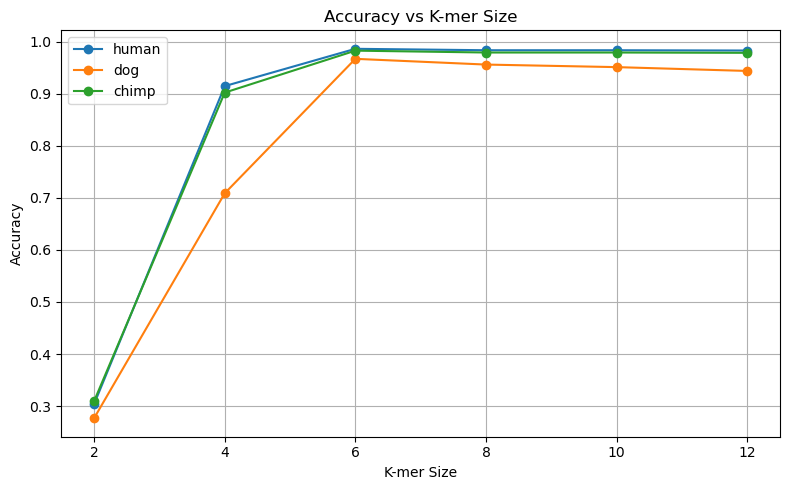

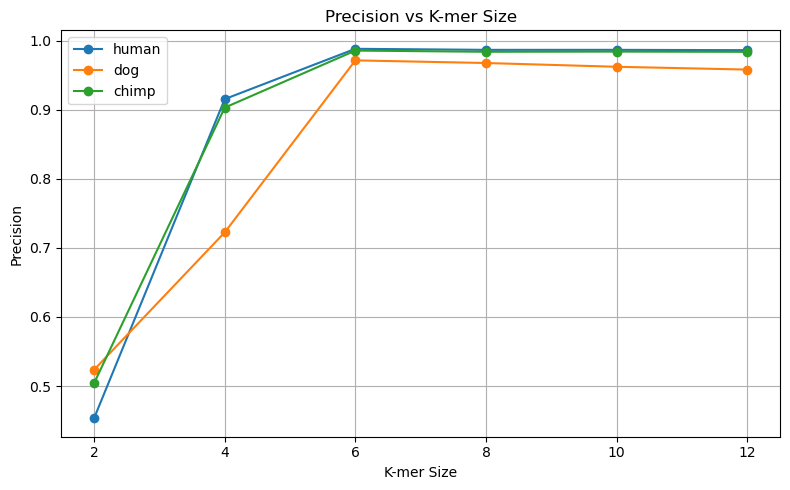

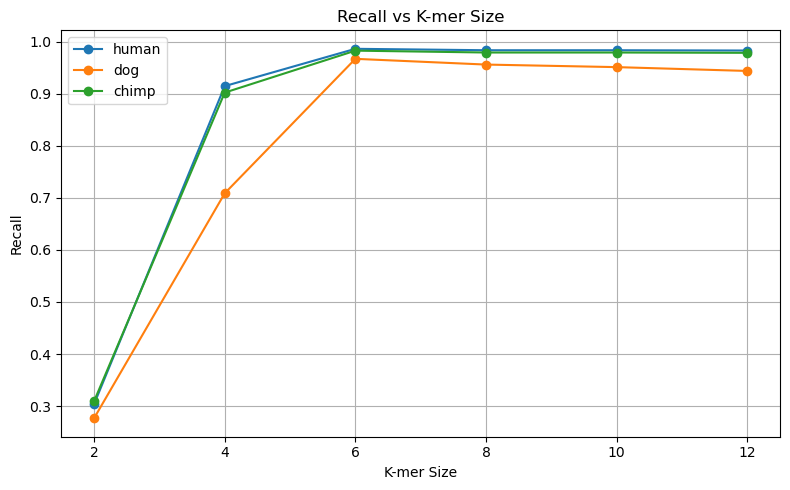

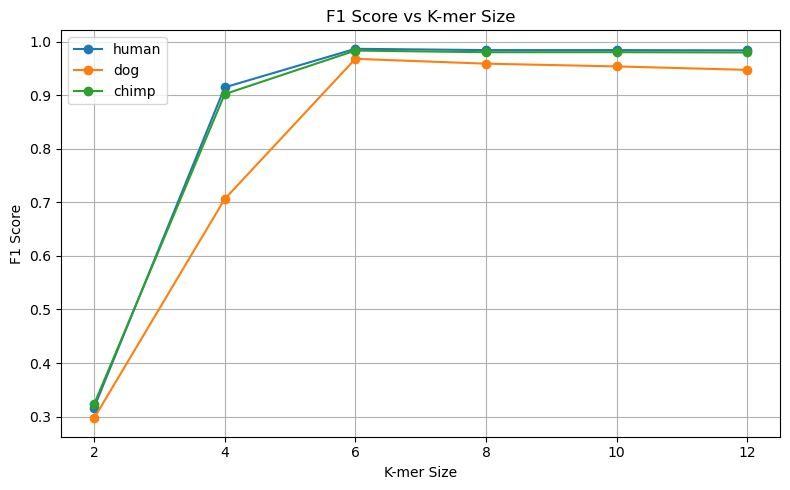

In [36]:
import matplotlib.pyplot as plt

# Metrics list for indexing
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Get sorted k-mers
kmer_values = sorted(metric_values_kmer.keys())

# Species
species = ['human', 'dog', 'chimp']

# Plot each metric separately
for i, metric_name in enumerate(metrics):
    plt.figure(figsize=(8, 5))

    for sp in species:
        metric_vals = [metric_values_kmer[k][sp][i] for k in kmer_values]
        plt.plot(kmer_values, metric_vals, marker='o', label=sp)

    plt.title(f'{metric_name} vs K-mer Size')
    plt.xlabel('K-mer Size')
    plt.ylabel(metric_name)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
